In [5]:
def plot_history(history):    
    import matplotlib.pyplot as plt

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Sequence processing and covnets
1D Convnets competitive with RNNs on certain sequence processing problems, with less computational cost.
1D Convets, with "dialeted kernels", used for audio generation and machine translation

ALSO, fast alternative to RNN for simple text classification and timeseries forecasting

In [1]:
# Conv1d: Input is: (samples, time, features)
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test_sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape', x_train.shape)
print('x_test shape', x_test.shape)

Using TensorFlow backend.


Loading data...
25000 train sequences
25000 test_sequences
Pad sequences (samples x time)
x_train shape (25000, 500)
x_test shape (25000, 500)


In [2]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=maxlen))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable para

In [3]:
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 8s 409us/step - loss: 0.8337 - acc: 0.5093 - val_loss: 0.6874 - val_acc: 0.5664
Epoch 2/10
20000/20000 [==============================] - 3s 172us/step - loss: 0.6699 - acc: 0.6392 - val_loss: 0.6641 - val_acc: 0.6590
Epoch 3/10
20000/20000 [==============================] - 3s 169us/step - loss: 0.6235 - acc: 0.7522 - val_loss: 0.6078 - val_acc: 0.7426
Epoch 4/10
20000/20000 [==============================] - 3s 169us/step - loss: 0.5259 - acc: 0.8077 - val_loss: 0.4826 - val_acc: 0.8050
Epoch 5/10
20000/20000 [==============================] - 3s 169us/step - loss: 0.4118 - acc: 0.8475 - val_loss: 0.4297 - val_acc: 0.8292
Epoch 6/10
20000/20000 [==============================] - 3s 168us/step - loss: 0.3501 - acc: 0.8672 - val_loss: 0.4147 - val_acc: 0.83

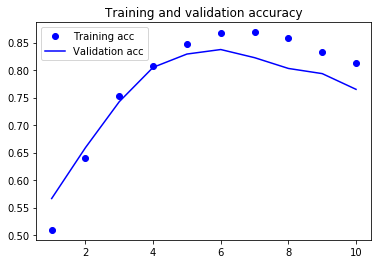

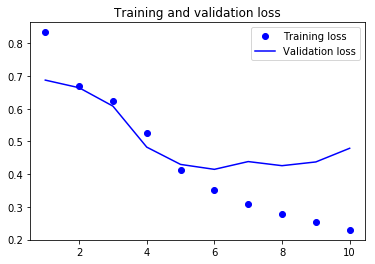

In [7]:
plot_history(history)

### Combining CNNs and RNNs to process LONG sequences
LONG SEQUENCE --> 1D CNN --> SHORTER SEQUENCE (CNN FEATURES) --> RNN -->

Essentially using 1D CNN as a preprocessing step: Especially beneficial when you're dealing with sequences so long they can't realistically be processed with RNNs - Such as sequences with 1000s of steps.

In [8]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1

    ## Shift the starting index
    nbatch = (max_index - min_index - lookback) // batch_size
    shift = max_index - min_index - lookback - nbatch*batch_size
    min_index_trunc = min_index + shift + lookback - 1

    i = min_index_trunc
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index_trunc, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index_trunc
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [10]:
import os
data_dir = r'C:\Users\pgbpr\Documents\Verusen\jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [11]:
step = 3 # previously set to 6
lookback = 720
delay = 144
batch_size = 128
train_gen = generator(
    float_data, 
    lookback=lookback, 
    delay=delay, 
    min_index=0, 
    max_index=200000, 
    shuffle=True, 
    step=step, 
    batch_size=batch_size)
val_gen = generator(
    float_data, 
    lookback=lookback, 
    delay=delay, 
    min_index=200001, 
    max_index=300000, 
    step=step, 
    batch_size=batch_size)
test_gen = generator(
    float_data, 
    lookback=lookback, 
    delay=delay, 
    min_index=300001, 
    max_index=None, 
    step=step, 
    batch_size=batch_size)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

print(model.summary())

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=5, validation_data=val_gen, validation_steps=val_steps)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1
500/500 

In [17]:
history.history

{'val_loss': [4.46951867365068], 'loss': [7.232866069793701]}

### Wrapping up
2D convets perform well for visual patterns, 1D convets perform well for processing temporal patterns (NLP). Faster than RNN
1D convets are stuctured like 2D equivalents
It's a good idea to use 1D convnets as a preprocessing step before RNNs, shortening the sequence and extracting useful representatiosn for RNNs to process